In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from scipy.stats import shapiro
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import scipy.stats
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal


# Part C: Gaussian Discriminant Analysis 

## C1. Dataset Preparation

### Loading Dataset

In [72]:
df = pd.read_csv("WineQT.csv")

df = df.drop("Id", axis=1)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Data Preprocessing

#### 1. Select Continuous features (at least 6 features)

In [73]:
X = df.drop("quality", axis=1)
Y = df["quality"]

#### 2. Check and ensure Gaussian assumptions are reasonably met

In [74]:
# Shapiro-Wilk normality test: Compares data to a perfect bell curve using calculations
# If p > 0.05: Data is Gaussian, else not
# We use only 500 because if we use all data, it will be too strict

for f in X.columns:
    stat, p = shapiro(X[f].sample(500, random_state=0).values) 
    # .sample(500, random_state=0): Randomly sample 500 rows, returns pandas series
    # shapiro expects 1D array, so use .values

    print(f"{f}: p={p:.4f} -> {'Gaussian-like' if p>0.05 else 'Not Gaussian'}")

fixed acidity: p=0.0000 -> Not Gaussian
volatile acidity: p=0.0000 -> Not Gaussian
citric acid: p=0.0000 -> Not Gaussian
residual sugar: p=0.0000 -> Not Gaussian
chlorides: p=0.0000 -> Not Gaussian
free sulfur dioxide: p=0.0000 -> Not Gaussian
total sulfur dioxide: p=0.0000 -> Not Gaussian
density: p=0.0008 -> Not Gaussian
pH: p=0.0794 -> Gaussian-like
sulphates: p=0.0000 -> Not Gaussian
alcohol: p=0.0000 -> Not Gaussian


#### 3. Apply feature scaling / standardization

In [75]:
scaler = StandardScaler()

X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#### 4. Handle Outliers appropriately

In [76]:
outlier_report = {}

for col in X_std.columns:
    
    Q1, Q3 = X_std[col].quantile([0.25, 0.75]) # Compute IQR bounds
    # .quantile: Computes 25th (Q1) and 75th (Q3) percentiles
    # ([0.25, 0.75]): Give me these quantiles/percentiles

    IQR = Q3 - Q1 # Inter-Quartile Range

    lower =  Q1 - 1.5 * IQR # lower boundary for outliers
    
    upper = Q3 + 1.5 * IQR # upper boundary for outliers
    
    before = ((X_std[col] < lower) | (X_std[col] > upper)).sum() # Count outliers before

    X_std[col] = np.clip(X_std[col], lower, upper) # Cap values
   
    after = ((X_std[col] < lower) | (X_std[col] > upper)).sum() # Count outliers after

    outlier_report[col] = {"before": before, "after": after} # Add results to dict 

print(pd.DataFrame(outlier_report))

        fixed acidity  volatile acidity  citric acid  residual sugar  \
before             44                14            1             110   
after               0                 0            0               0   

        chlorides  free sulfur dioxide  total sulfur dioxide  density  pH  \
before         77                   18                    40       36  20   
after           0                    0                     0        0   0   

        sulphates  alcohol  
before         43       12  
after           0        0  


#### 5. Create 70/15/15 stratified split

In [77]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_std,Y,test_size=0.3,random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_temp,Y_temp,test_size=0.5,random_state=42)

print(f"X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}\n")
print(f"Y_train: {len(Y_train)}, Y_val: {len(Y_val)}, Y_test: {len(Y_test)}")

X_train: 800, X_val: 171, X_test: 172

Y_train: 800, Y_val: 171, Y_test: 172


#### 6. Visualize feature distributions and class separability 

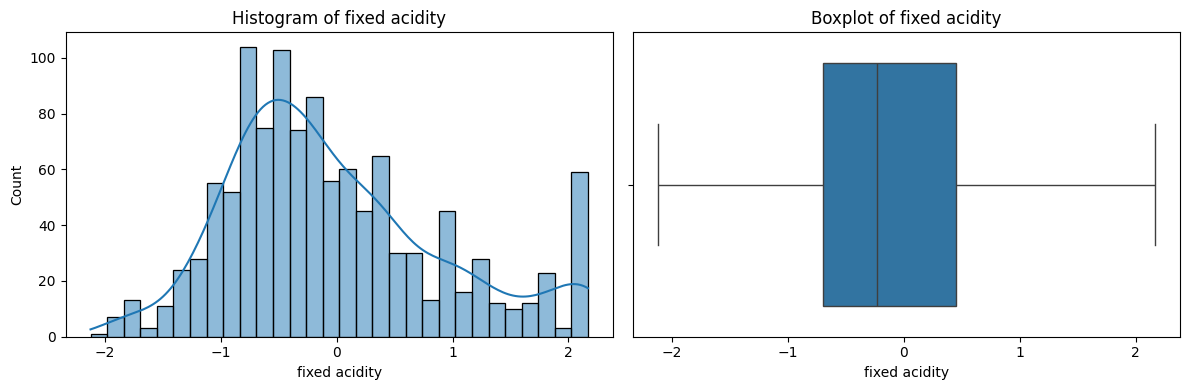

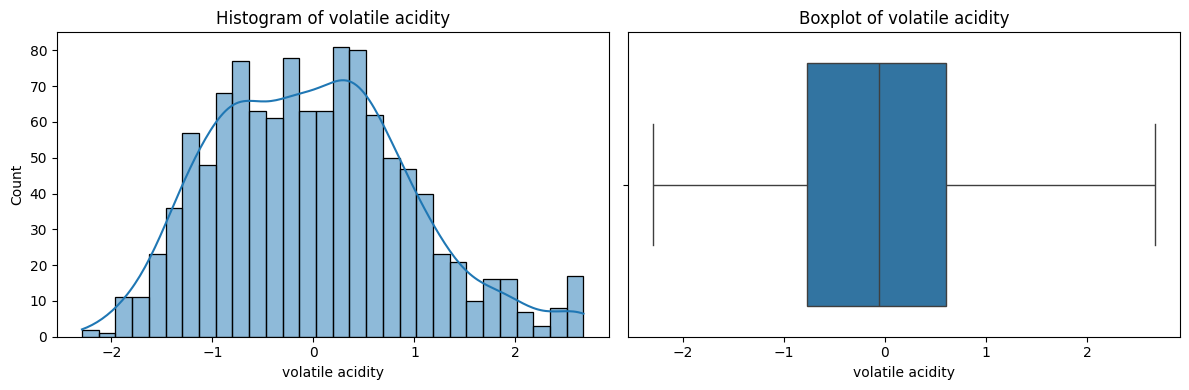

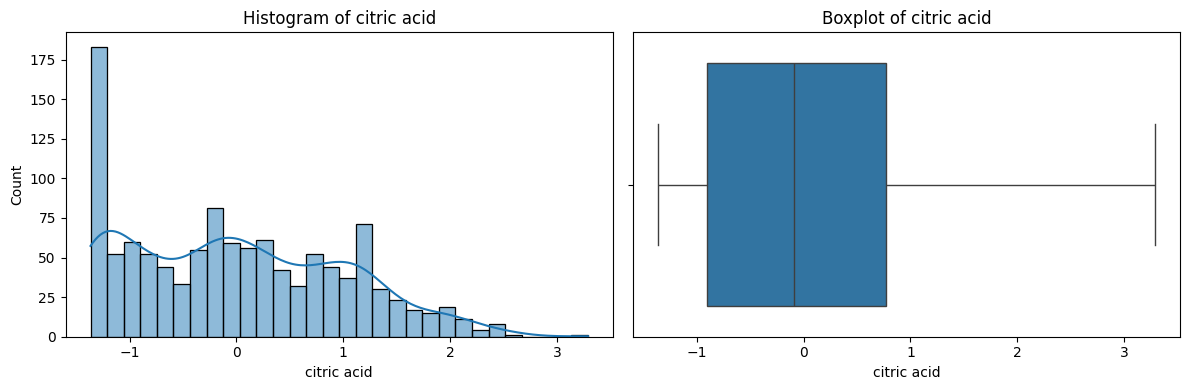

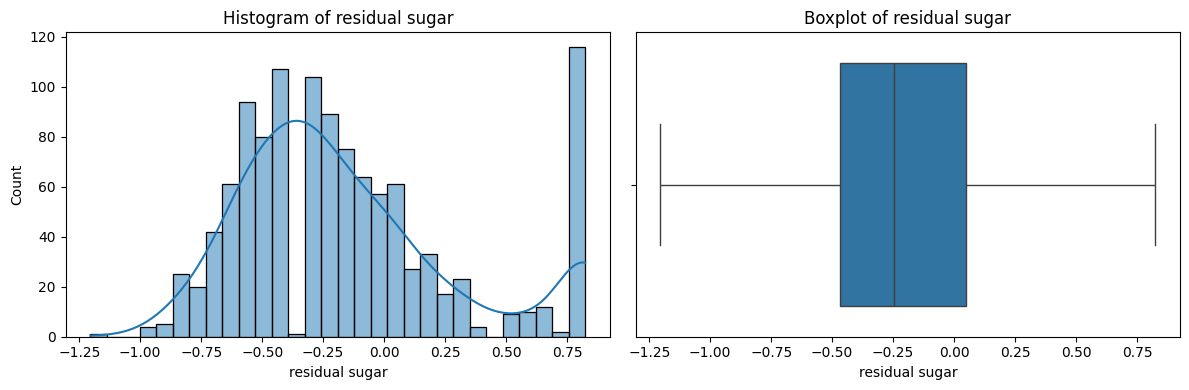

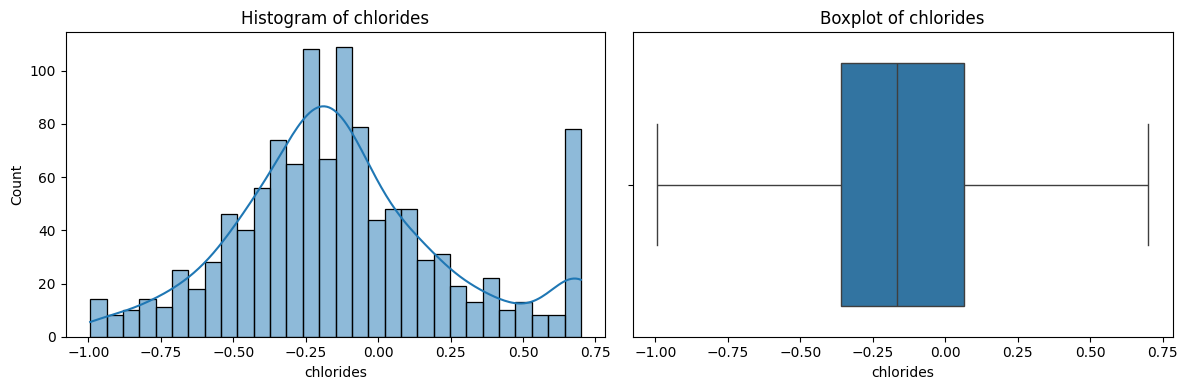

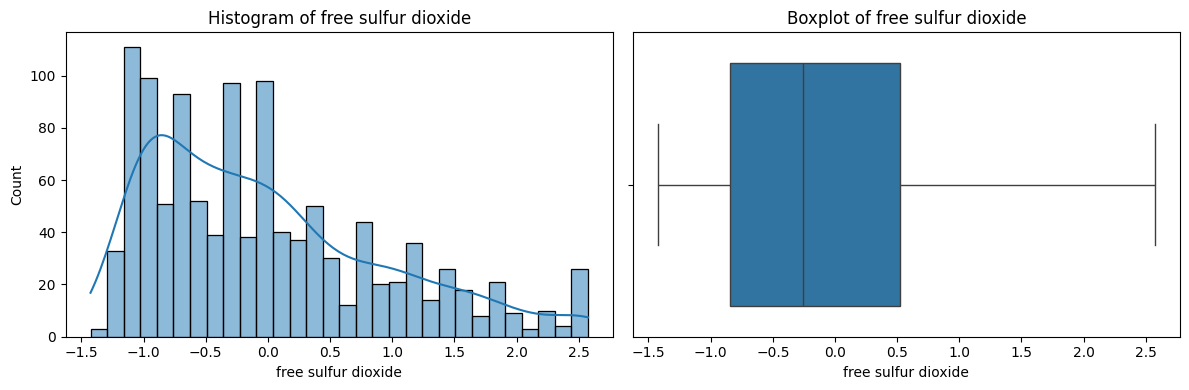

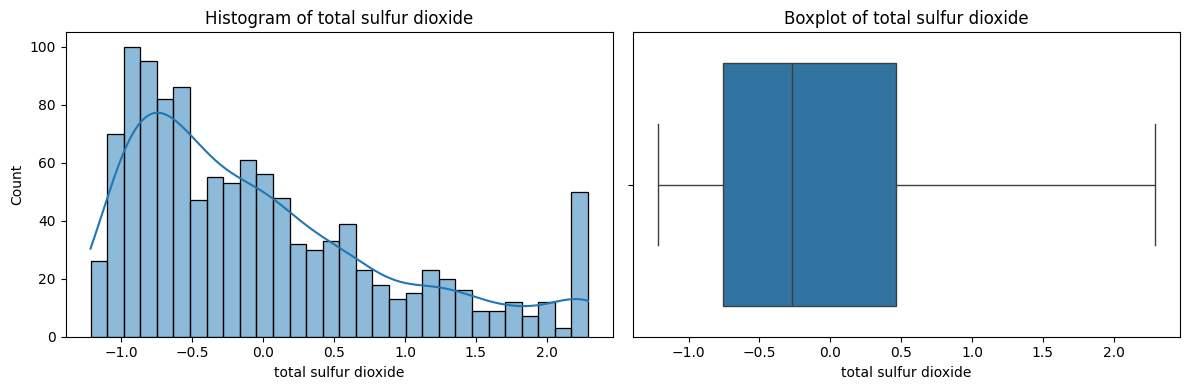

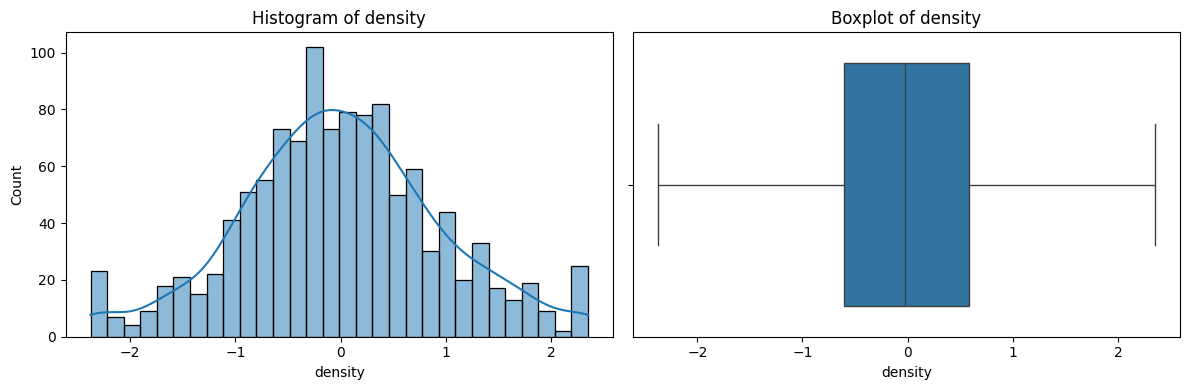

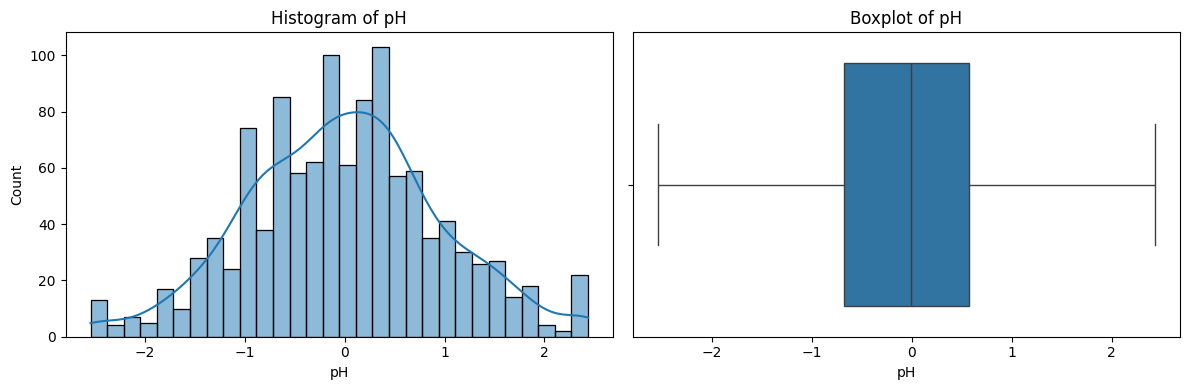

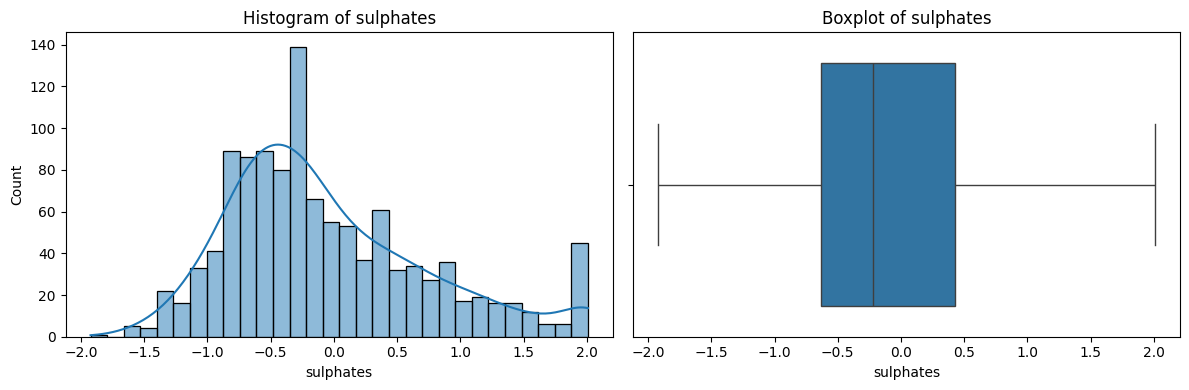

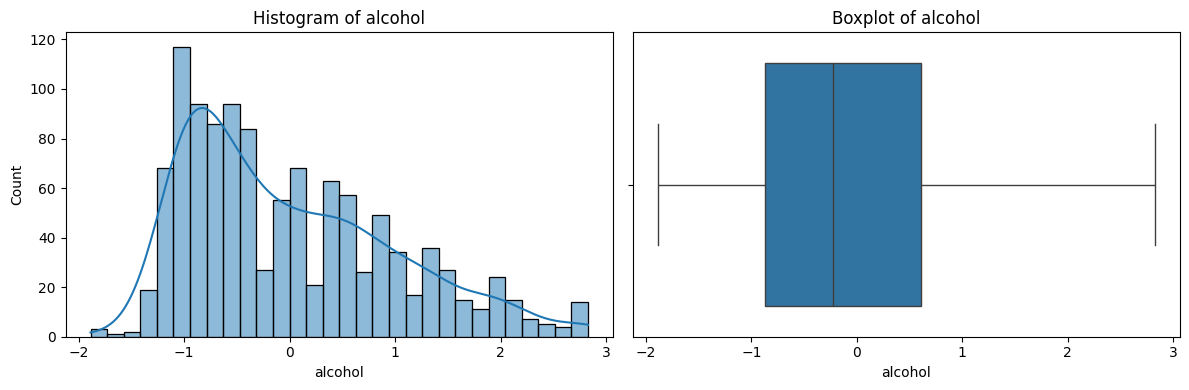

In [78]:
for col in X_std.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 1. Histogram + KDE
    sns.histplot(X_std[col], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")

    # 2. Boxplot
    sns.boxplot(x=X_std[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()


## C2. Gaussian Discriminant Analysis Implementation (Mathematical Implementation)

In [79]:
Xtr_np = X_train.values                  # numpy array of features (train) [xi]
Ytr_np = Y_train.values                  # numpy array of labels (train) [yi]
classes, counts = np.unique(Ytr_np, return_counts=True)  # unique class labels + their counts
n, d = Xtr_np.shape                      # n = number of samples, d = number of features

print("Classes: ", classes)
print("Counts: ", counts)
print("Number of samples: ", n)
print("Number of features: ", d)

Classes:  [3 4 5 6 7 8]
Counts:  [  6  24 340 316 102  12]
Number of samples:  800
Number of features:  11


### Our Model (Contains the following):

#### 1. Class Priors
#### 2. Class Means
#### 3. Covariance Matrices
##### a. Individual
##### b. Shared

In [ ]:
class OurGaussianClassifier:
    # self is the reference of the current instance of the class
    def __init__(self, shared=True, reg=1e-6):
        self.shared = shared # If True, use a single covariance matrix 
        self.reg = reg # Regularization 
        self.means = {} # Stores Mean Vector for each class
        self.covariances = {} # Store covariance matrix for each class if shared is False
        self.priors = {} # Store prior probabilities for each class
        self.shared_cov_ = None # Store the shared covariance matrix
        self.classes = None # Store list of unique class labels

    def fit(self, X, y):
        # Convert X and Y to numpy so we can use np.unique
        X = np.asarray(X)
        y = np.asarray(y)
        
        self.classes, counts = np.unique(y, return_counts=True)

        # 1. Class Priors (P(Number of points in class / Total number of points))
        for cls, cnt in zip(self.classes, counts): # Loops over pairs of class labels and counts
            self.priors[cls] = cnt / len(y) # Calculate & Store prior probabilities

        # 2 and 3a. Class Means and Individual Covariance Matrices
        for cls in self.classes: # Loop through each class
            X_c = X[y == cls] # Get all samples that belong to class cls
            mu = X_c.mean(axis=0) # Calculate mean vector, down the rows (for each column), so each element is the mean of that feature for the current class
            cov = np.cov(X_c, rowvar=False) # Calculate covariance matrix
            # rowvar=False: indicates that each column of X_c represents a variable (a feature), and each row is an observation (a data point).
            cov += self.reg * np.eye(cov.shape[0]) # Add regularization
            # np.eye(cov.shape[0]): creates an identity matrix of size cov.shape[0] (d) (1 on diagonal, 0 elsewhere)
            # Scales identity matrix using self.reg
            self.means[cls] = mu # Store calculated mean vector in dictionary
            self.covariances[cls] = cov # Store calculated covariance matrix in dictionary

        # 3b. Shared Covariance Matrices 
        if self.shared: # If shared = True
            d = X.shape[1] # Number of features
            num = np.zeros((d, d)) # Initialize matrix of size dxd of zeros
            for cls in self.classes:
                n_c = (y == cls).sum() # Count number of samples with label
                num += (n_c - 1) * self.covariances[cls] # calculates weighted sum
                # we use n_c -1 because np.cov uses n-1 as denominator for sample variance
            self.shared_cov_ = num / (len(y) - len(self.classes)) # Calculate shared covariance matrix
            self.shared_cov_ += self.reg * np.eye(d) # Add regularization

        return self

    def predict(self, X):
        X = np.asarray(X)
        preds = []
        for x in X:
            scores = {}
            for cls in self.classes:
                mean = self.means[cls] # Get mean vector
                cov = self.shared_cov_ if self.shared else self.covariances[cls] # Get covariance matrix
                lp = multivariate_normal.logpdf(x, mean=mean, cov=cov) + np.log(self.priors[cls]) # Calculate log-likelihood
                scores[cls] = lp # Store log-likelihood
            preds.append(max(scores, key=scores.get)) 
            # preduct and append the class label with the highest log-likelihood
        return np.array(preds)


our_model = OurGaussianClassifier(shared=True)  # shared=True → LDA-like, shared=False → QDA-like
our_model.fit(X_train.values, Y_train.values)


## C3. Analysis and Evaluation

### 1. Covariance Assumptions: Compare Shared vs Individual Covariance Matrices

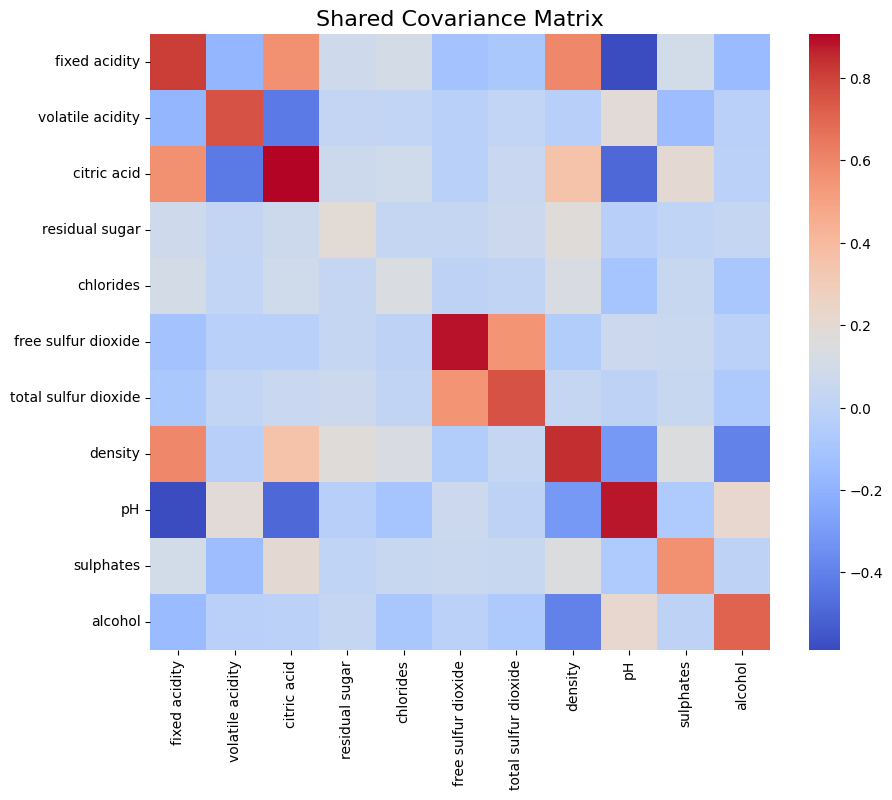

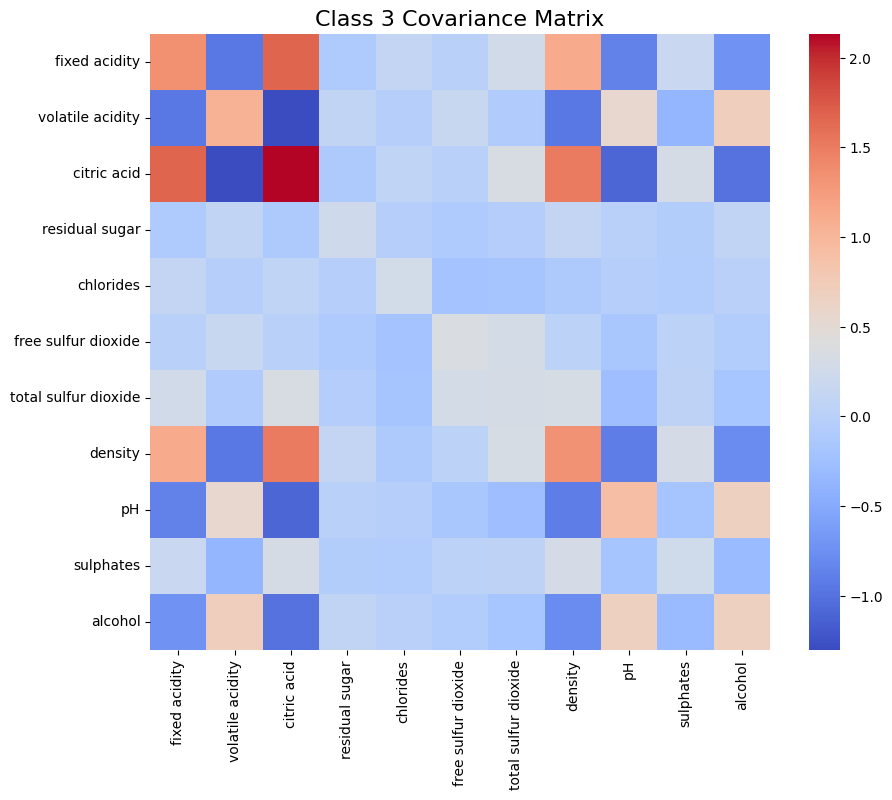

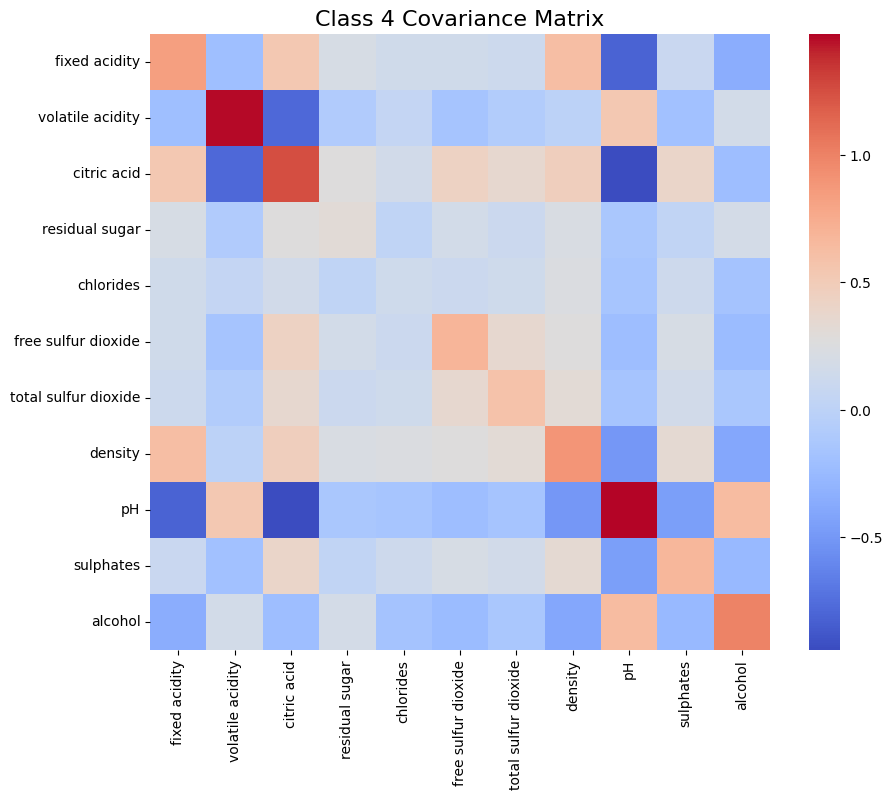

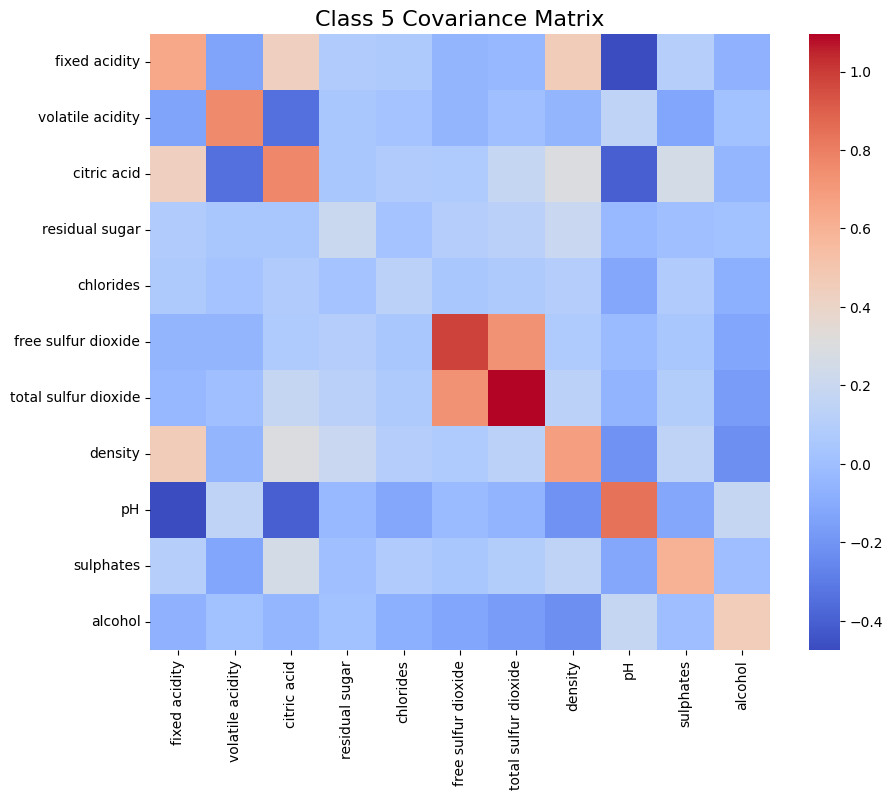

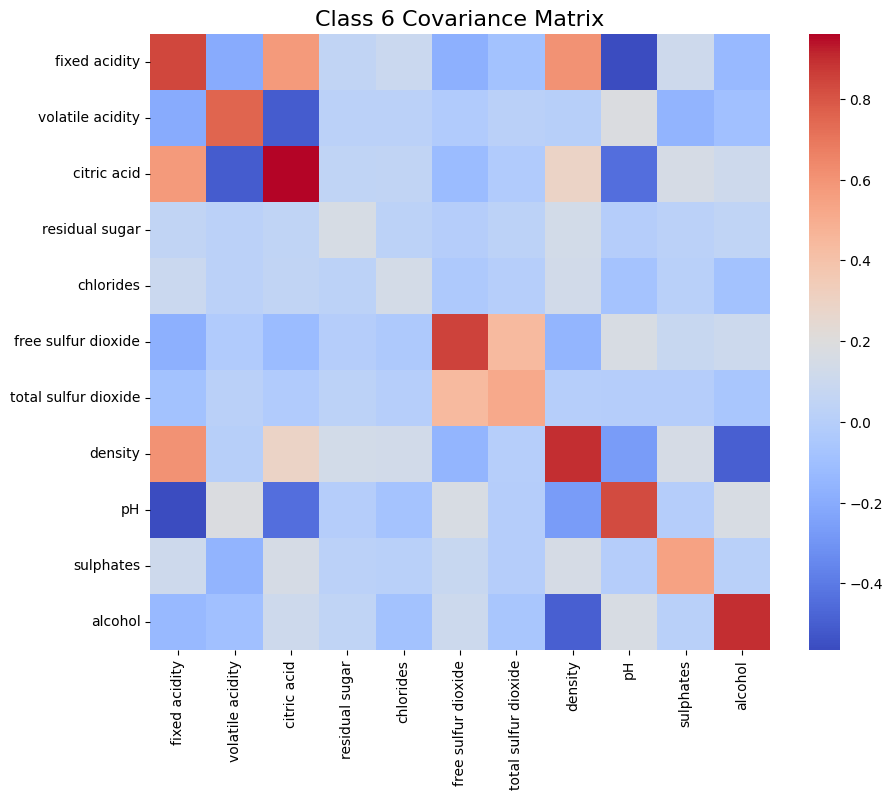

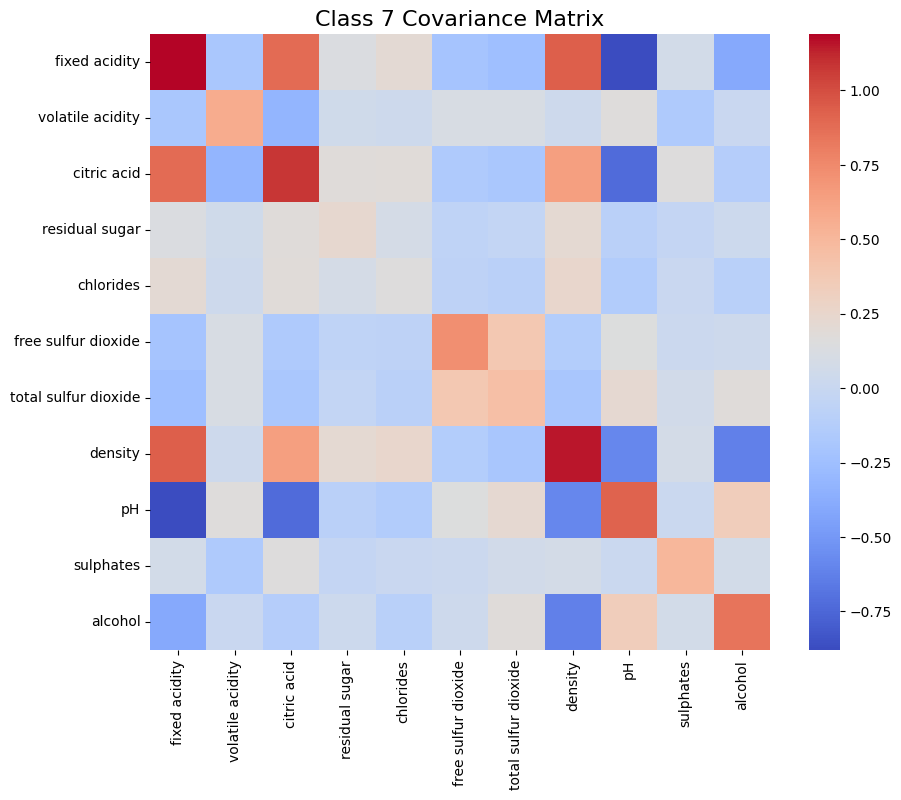

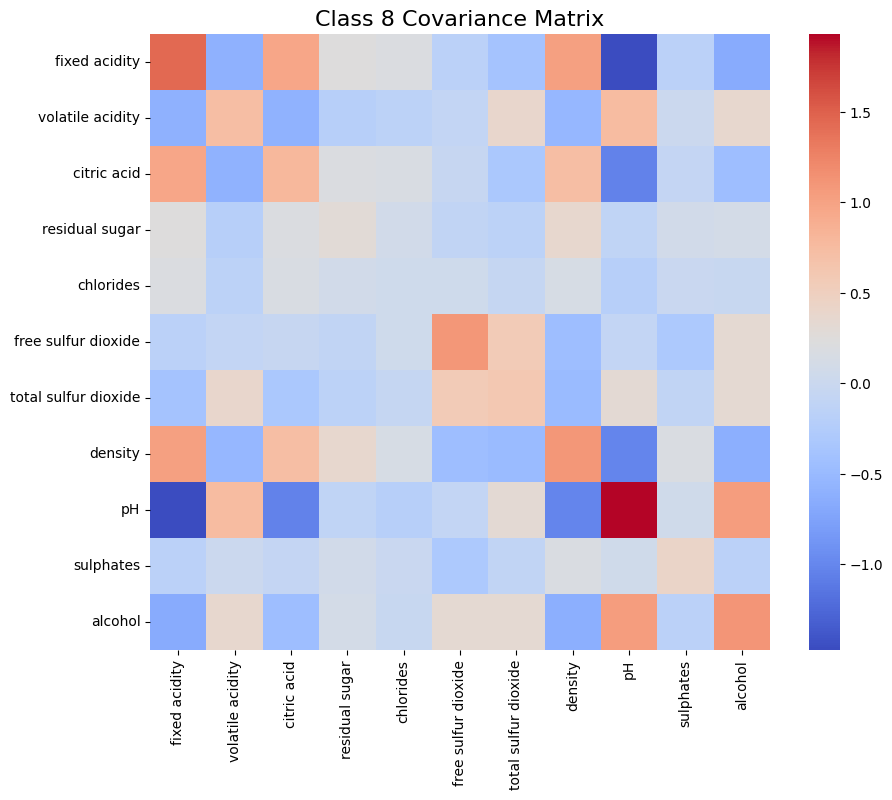

In [ ]:
# Shared covariance from the model
plt.figure(figsize=(10, 8))
sns.heatmap(our_model.shared_cov_, cmap="coolwarm", cbar=True,
            xticklabels=X_train.columns, yticklabels=X_train.columns)
plt.title("Shared Covariance Matrix", fontsize=16)
plt.show()

# Individual covariances from the model
for c in our_model.classes_:
    plt.figure(figsize=(10, 8))
    sns.heatmap(our_model.covariances[c], cmap="coolwarm", cbar=True,
                xticklabels=X_train.columns, yticklabels=X_train.columns)
    plt.title(f"Class {c} Covariance Matrix", fontsize=16)
    plt.show()

# -------------------------------------------------------------------------------------
# red areas: +ve covariance / relationship
# blue areas: -ve covariance / relationship
# white areas: no relationship
# Diagonals are +ve because they are variances, always non-negative
# When using shared covariance matrix, all covariance matrices are the same
# LDA: Linear Decision Boundary
# QDA: Quadratic Decision Boundary
# We add reg to avoid singular matrices and stabilize the model


### 2. Feature Correlation: Analyze Impact of Correlated Features

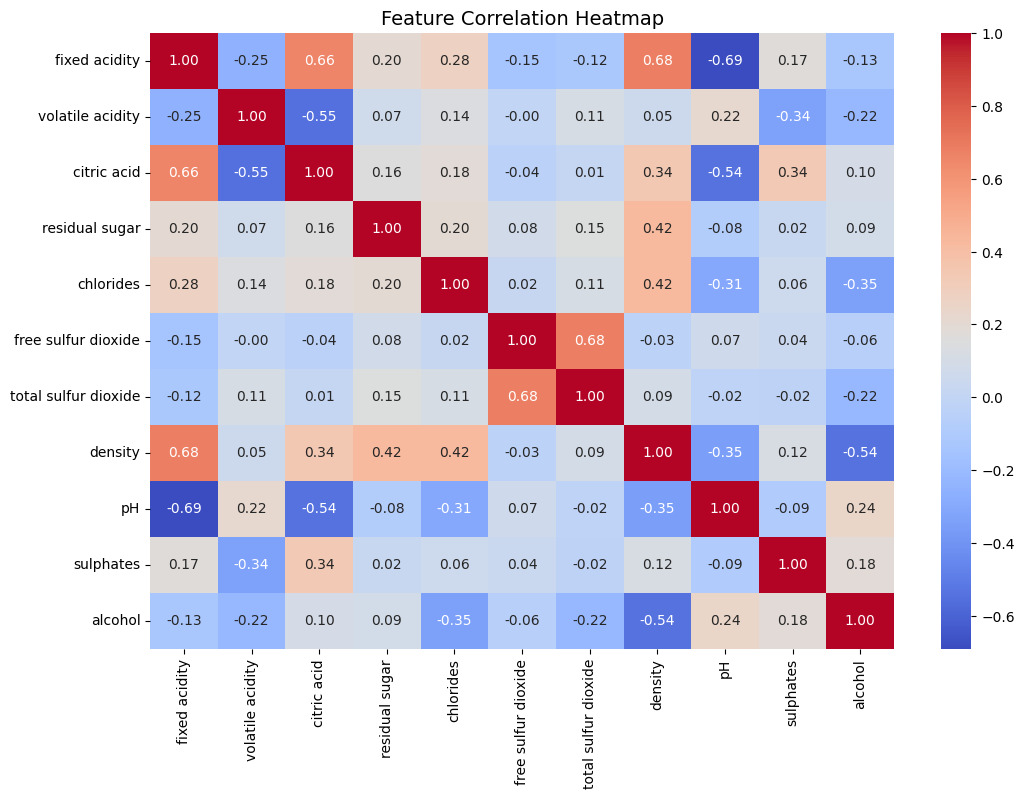

In [100]:
# Feature Correlation Heatmap
corr_matrix = X_train.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


### 3. Gaussian Assumptions: Test normality assumptions and their violations

In [ ]:
# Dictionary to store results
gaussian_test_results = {}

for f in X_train.columns:
    stat, p = shapiro(X_train[f].sample(min(500, len(X_train)), random_state=0).values)
    gaussian_test_results[f] = {
        "W-statistic": stat, # closer to 1 indicates the sample is closer to normality (less skewness) 
        "p-value": p, # closer to 0 indicates the sample is closer to normality
        "Gaussian-like?": "Yes" if p > 0.05 else "No"
    }

gaussian_df = pd.DataFrame(gaussian_test_results).T
print(gaussian_df)

                     W-statistic   p-value Gaussian-like?
fixed acidity           0.950223       0.0             No
volatile acidity        0.980865  0.000004             No
citric acid             0.949851       0.0             No
residual sugar          0.911934       0.0             No
chlorides               0.970901       0.0             No
free sulfur dioxide     0.921237       0.0             No
total sulfur dioxide     0.90347       0.0             No
density                 0.993117  0.021786             No
pH                      0.995398  0.146739            Yes
sulphates               0.941176       0.0             No
alcohol                 0.932752       0.0             No


### 4. Dimensionality: Analyze performance with different numbers of features

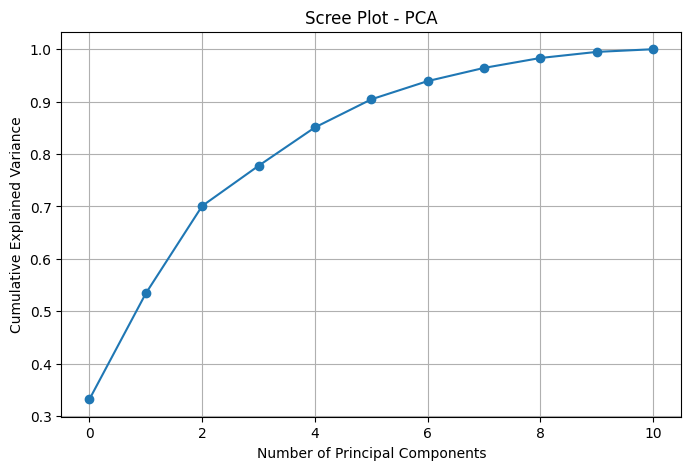

In [102]:
# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot - PCA")
plt.grid(True)
plt.show()


### 5. Comparison: Compare with SKLearn's LinearDiscriminantAnalysis and QuadraticDiscriminantAnalysis

In [109]:
# === Model Evaluation (Our Model vs LDA vs QDA) ===
y_pred_our = our_model.predict(X_test.values)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
y_pred_lda = lda.predict(X_test)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, Y_train)
y_pred_qda = qda.predict(X_test)

print("Accuracies: ")
print("Our Model: ", accuracy_score(Y_test, y_pred_our))
print("LDA: ", accuracy_score(Y_test, y_pred_lda))
print("QDA: ", accuracy_score(Y_test, y_pred_qda))

# Our = LDA because we use shared variance and shared = True, if = False then QDA

print("\nConfusion Matrices: ")
print("Our Model: ", confusion_matrix(Y_test, y_pred_our))
print("LDA: ", confusion_matrix(Y_test, y_pred_lda))
print("QDA: ", confusion_matrix(Y_test, y_pred_qda))

Accuracies: 
Our Model:  0.6104651162790697
LDA:  0.6104651162790697
QDA:  0.5465116279069767

Confusion Matrices: 
Our Model:  [[ 0  0  0  0  0  0]
 [ 0  1  3  2  0  0]
 [ 1  0 58 20  2  0]
 [ 0  0 21 37  7  0]
 [ 0  0  0  8  9  0]
 [ 0  0  0  1  2  0]]
LDA:  [[ 0  0  0  0  0  0]
 [ 0  1  3  2  0  0]
 [ 1  0 58 20  2  0]
 [ 0  0 21 37  7  0]
 [ 0  0  0  8  9  0]
 [ 0  0  0  1  2  0]]
QDA:  [[ 0  4  2  0  0]
 [ 2 53 24  2  0]
 [ 0 25 33  7  0]
 [ 0  1  7  8  1]
 [ 0  0  2  1  0]]


c:\Users\HP\anaconda3\envs\myenv2\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
